In [18]:
!pip install pulp

zsh:1: command not found: pip


In [2]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from pulp import LpVariable, LpBinary, LpMinimize, LpProblem, lpSum, value


In [3]:
def posibles_posiciones(ships_len, orientations, rows, cols):
        nro_cols = len(cols)
        nro_rows = len(rows)
        potentially_positions = {}
        for ship, ship_len in enumerate(ships_len):
            for o in orientations:
                if o == 'H':
                    position = [
                        (i, j) for i in range(nro_rows) for j in range(nro_cols - ship_len + 1)
                        if sum(rows[i:j + ship_len]) > 0
                    ]
                elif o == 'V':
                    position = [
                        (i, j) for i in range(nro_rows - ship_len + 1) for j in range(nro_cols)
                        if sum(cols[j:i + ship_len]) > 0
                    ]
                potentially_positions[(ship, o)] = position
        return potentially_positions

def calcular_celdas_adyacentes(n, m, covered_cells):
    # Calcula las celdas adyacentes a las celdas ocupadas por un barco
    adjacent_cells = set()
    for (i_cell, j_cell) in covered_cells:
        for delta_i in [-1, 0, 1]:
            for delta_j in [-1, 0, 1]:
                i_adj, j_adj = i_cell + delta_i, j_cell + delta_j
                if 0 <= i_adj < n and 0 <= j_adj < m and (i_adj, j_adj) not in covered_cells:
                    adjacent_cells.add((i_adj, j_adj))
    return adjacent_cells
def resolve_batalla_naval(nro_filas, nro_columnas, ships_len, rows, cols, posibles_posiciones):
    ships = list(range(len(ships_len)))  # Barcos enumerados
    orientations = ['H', 'V']  # Horizontal (H) o Vertical (V)

    # Variables de decisión
    barco_en_celda = LpVariable.dicts(
        "barco_en_celda",
        [(ship, o, i, j) for ship in ships for o in orientations for (i, j) in posibles_posiciones[(ship, o)]],
        0, 1, LpBinary
    )
    barco_no_colocado = LpVariable.dicts("barco_no_colocado", ships, 0, 1, LpBinary)

    # Modelo y función objetivo
    prob = LpProblem("LaBatallaNaval", LpMinimize)
    prob += (
        sum(rows[i] - lpSum(
            lpSum(
                barco_en_celda[(ship, o, i_start, j_start)]
                for ship in ships
                for o in orientations
                for (i_start, j_start) in posibles_posiciones[(ship, o)]
                if (o == 'H' and i_start == i and j_start <= j < j_start + ships_len[ship]) or
                   (o == 'V' and j_start == j and i_start <= i < i_start + ships_len[ship])
            )
            for j in range(nro_columnas)
        ) for i in range(nro_filas)) +
        sum(cols[j] - lpSum(
            lpSum(
                barco_en_celda[(ship, o, i_start, j_start)]
                for ship in ships
                for o in orientations
                for (i_start, j_start) in posibles_posiciones[(ship, o)]
                if (o == 'H' and i_start == i and j_start <= j < j_start + ships_len[ship]) or
                   (o == 'V' and j_start == j and i_start <= i < i_start + ships_len[ship])
            )
            for i in range(nro_filas)
        ) for j in range(nro_columnas)),
        "Demanda incumplida"
    )

    # Restricción 1: Cada barco se coloca exactamente una vez o no se coloca
    for ship in ships:
        prob += lpSum(barco_en_celda[(ship, o, i, j)] for o in orientations for (i, j) in posibles_posiciones[(ship, o)]) + barco_no_colocado[ship] == 1

    # Restricción 2: No superposición de barcos
    for i in range(nro_filas):
        for j in range(nro_columnas):
            prob += lpSum(
                barco_en_celda[(ship, o, i_start, j_start)]
                for ship in ships
                for o in orientations
                for (i_start, j_start) in posibles_posiciones[(ship, o)]
                if (o == 'H' and i_start == i and j_start <= j < j_start + ships_len[ship]) or
                   (o == 'V' and j_start == j and i_start <= i < i_start + ships_len[ship])
            ) <= 1

    # Restricción 3: No adyacencia entre barcos
    for ship in ships:
        ship_len = ships_len[ship]
        for o in orientations:
            for (i, j) in posibles_posiciones[(ship, o)]:
                covered_cells = [(i, j + offset) for offset in range(ship_len)] if o == 'H' else [(i + offset, j) for offset in range(ship_len)]
                adjacent_cells = calcular_celdas_adyacentes(nro_filas, nro_columnas, covered_cells)
                for (i_adj, j_adj) in adjacent_cells:
                    prob += lpSum(
                        barco_en_celda[(ship_adj, o_adj, i_start, j_start)]
                        for ship_adj in ships
                        for o_adj in orientations
                        for (i_start, j_start) in posibles_posiciones[(ship_adj, o_adj)]
                        if (o_adj == 'H' and i_start == i_adj and j_start <= j_adj < j_start + ships_len[ship_adj]) or
                           (o_adj == 'V' and j_start == j_adj and i_start <= i_adj < i_start + ships_len[ship_adj])
                    ) + barco_en_celda[(ship, o, i, j)] <= 1

    # Restricción 4: Demanda máxima por fila
    for i in range(nro_filas):
        prob += lpSum(
            lpSum(
                barco_en_celda[(ship, o, i_start, j_start)]
                for ship in ships
                for o in orientations
                for (i_start, j_start) in posibles_posiciones[(ship, o)]
                if (o == 'H' and i_start == i and j_start <= j < j_start + ships_len[ship]) or
                   (o == 'V' and j_start == j and i_start <= i < i_start + ships_len[ship])
            )
            for j in range(nro_columnas)
        ) <= rows[i]

    # Restricción 5: Demanda máxima por columna
    for j in range(nro_columnas):
        prob += lpSum(
            lpSum(
                barco_en_celda[(ship, o, i_start, j_start)]
                for ship in ships
                for o in orientations
                for (i_start, j_start) in posibles_posiciones[(ship, o)]
                if (o == 'H' and i_start == i and j_start <= j < j_start + ships_len[ship]) or
                   (o == 'V' and j_start == j and i_start <= i < i_start + ships_len[ship])
            )
            for i in range(nro_filas)
        ) <= cols[j]

    # Resolver el modelo
    prob.solve()
    return prob, barco_en_celda

def reconstruir_tablero_y_calcular_demanda(n, m, matriz_resuelta, ships_len, rows, cols):
    tablero = [["-"] * m for _ in range(n)]

    # Recorre todas las variables de decisión
    for (ship, o, i, j), var in matriz_resuelta.items():
        if value(var) > 0.5:  # Si hay barco
            ship_len = ships_len[ship]
            if o == 'H':
                for offset in range(ship_len):
                    tablero[i][j + offset] = "1"
            elif o == 'V':
                for offset in range(ship_len):
                    tablero[i + offset][j] = "1"

    demanda_filas = [sum(1 for j in range(m) if tablero[i][j] == "1") for i in range(n)]
    demanda_columnas = [sum(1 for i in range(n) if tablero[i][j] == "1") for j in range(m)]

    demanda_total_cumplida = sum(min(demanda_filas[i], rows[i]) for i in range(n)) + \
                             sum(min(demanda_columnas[j], cols[j]) for j in range(m))
    demanda_total = sum(rows) + sum(cols)

    return tablero, demanda_total_cumplida, demanda_total


In [4]:
def programacion_lineal(matriz, barcos, restricciones_fil, restricciones_col):

  n, m = len(restricciones_fil), len(restricciones_col)
  orientations = ['H', 'V']
  posiciones = posibles_posiciones(barcos, orientations, restricciones_fil, restricciones_col)
  _ , matriz_resuelta = resolve_batalla_naval(n, m, barcos, restricciones_fil, restricciones_col, posiciones)

  return matriz_resuelta

In [5]:
def ejecutar_ejemplo_aleatorio(matriz, barcos, restricciones_fil, restricciones_col):
    start_time = time.time()
    matriz_resuelta = programacion_lineal(
        matriz, barcos, restricciones_fil, restricciones_col)
    tiempo_exacto = time.time() - start_time

    tablero_reconstruido, demanda_cumplida, demanda_total = reconstruir_tablero_y_calcular_demanda(
        len(restricciones_fil), len(restricciones_col), matriz_resuelta, barcos, restricciones_fil, restricciones_col
    )

    print("Tablero reconstruido:")
    for fila in tablero_reconstruido:
        print(" ".join(fila))

    print(f"Demanda cumplida: {demanda_cumplida}")
    print(f"Demanda total: {demanda_total}")
    print(f"Tiempo resolucion: {tiempo_exacto}")

    return tiempo_exacto

In [6]:
#Ejemplo 3_3_2.txt
matriz3_3_2 = [[0] * 3 for _ in range(3)]
barcos3_3_2 = [1,1]
res_fil3_3_2 = [3,1,2]
res_col3_3_2 = [3,2,0]

tiempo3_3_2 = ejecutar_ejemplo_aleatorio(
    matriz3_3_2, barcos3_3_2, res_fil3_3_2, res_col3_3_2)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/fa0112887cbf49299649d6d6e886a2c6-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/fa0112887cbf49299649d6d6e886a2c6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 124 COLUMNS
At line 643 RHS
At line 763 BOUNDS
At line 788 ENDATA
Problem MODEL has 119 rows, 24 columns and 448 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -4 - 0.00 seconds
Cgl0002I 6 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 71 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 68 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 68 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tight

In [7]:
#Ejemplo 5_5_6.txt
matriz5_5_6 = [[0] * 5 for _ in range(5)]
barcos5_5_6 = [1,2,2,2,2,1]
res_fil5_5_6 = [3,3,0,1,1]
res_col5_5_6 = [3,1,0,3,3]

tiempo5_5_6 = ejecutar_ejemplo_aleatorio(
    matriz5_5_6, barcos5_5_6, res_fil5_5_6, res_col5_5_6)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/395cc7068c1348a89843e7f9f87d85ab-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/395cc7068c1348a89843e7f9f87d85ab-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 1098 COLUMNS
At line 14921 RHS
At line 16015 BOUNDS
At line 16182 ENDATA
Problem MODEL has 1093 rows, 166 columns and 13330 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -16 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 198 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 199 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 198 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds,

In [8]:
#Ejemplo 8_7_10.txt
matriz8_7_10 = [[0] * 7 for _ in range(8)]
barcos8_7_10 = [2,1,2,2,1,3,2,7,7,7]
res_fil8_7_10 = [1,4,4,4,3,3,4,4]
res_col8_7_10 = [6,5,3,0,6,3,3]

tiempo8_7_10 = ejecutar_ejemplo_aleatorio(
    matriz8_7_10, barcos8_7_10, res_fil8_7_10, res_col8_7_10)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/4203847ab6fc4ab2bdb3b4a418dcf542-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/4203847ab6fc4ab2bdb3b4a418dcf542-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4297 COLUMNS
At line 110395 RHS
At line 114688 BOUNDS
At line 115182 ENDATA
Problem MODEL has 4292 rows, 493 columns and 104628 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -52 - 0.04 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2015 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1912 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1801 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened 

In [9]:
#Ejemplo 10_3_3.txt
matriz10_3_3 = [[0] * 3 for _ in range(10)]
barcos10_3_3 = [3,3,4]
res_fil10_3_3 = [1,0,1,0,1,0,0,1,1,1]
res_col10_3_3 = [1,4,3]

tiempo10_3_3 = ejecutar_ejemplo_aleatorio(
    matriz10_3_3, barcos10_3_3, res_fil10_3_3, res_col10_3_3)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/4f79ccb57ca744a89675b191f844bdd7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/4f79ccb57ca744a89675b191f844bdd7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 665 COLUMNS
At line 7582 RHS
At line 8243 BOUNDS
At line 8322 ENDATA
Problem MODEL has 660 rows, 78 columns and 6685 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -10 - 0.00 seconds
Cgl0002I 57 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 6 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc

In [10]:
#Ejemplo 10_10_10.txt
matriz10_10_10 = [[0] * 10 for _ in range(10)]
barcos10_10_10 = [4,3,3,2,2,2,1,1,1,1]
res_fil10_10_10 = [3,2,2,4,2,1,1,2,3,0]
res_col10_10_10 = [1,2,1,3,2,2,3,1,5,0]

tiempo10_10_10 = ejecutar_ejemplo_aleatorio(
    matriz10_10_10, barcos10_10_10, res_fil10_10_10, res_col10_10_10)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/c83ad030c9fe401ea675033138f37de5-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/c83ad030c9fe401ea675033138f37de5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9243 COLUMNS
At line 236386 RHS
At line 245625 BOUNDS
At line 246686 ENDATA
Problem MODEL has 9238 rows, 1060 columns and 223972 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -40 - 0.05 seconds
Cgl0002I 180 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2384 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2032 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1224 strengthened rows, 0 substitutions


In [11]:
#Ejemplo 12_12_21.txt
matriz12_12_21 = [[0] * 12 for _ in range(12)]
barcos12_12_21 = [4,3,7,4,3,2,2,5,5,5,4,4,5,5,7,6,4,1,7,4,4]
res_fil12_12_21 = [3,6,1,2,3,6,5,2,0,3,0,3]
res_col12_12_21 = [3,0,1,1,3,1,0,3,3,4,1,4]

tiempo12_12_21 = ejecutar_ejemplo_aleatorio(
    matriz12_12_21, barcos12_12_21, res_fil12_12_21, res_col12_12_21)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/412b6aee8fda440ea2d5de5f0e47fd51-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/412b6aee8fda440ea2d5de5f0e47fd51-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 36887 COLUMNS
At line 3744389 RHS
At line 3781272 BOUNDS
At line 3784148 ENDATA
Problem MODEL has 36882 rows, 2875 columns and 3698897 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -44 - 0.74 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2480 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2472 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2431 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tig

In [12]:
#Ejemplo 15_10_15.txt
matriz15_10_15 = [[0] * 10 for _ in range(15)]
barcos15_10_15 = [6,2,1,8,7,2,7,2,5,8,1,8,8,1,6]
res_fil15_10_15 = [0,3,4,1,1,4,5,0,4,5,4,2,4,3,2]
res_col15_10_15 = [0,0,3,4,1,4,6,5,2,0]

tiempo15_10_15 = ejecutar_ejemplo_aleatorio(
    matriz15_10_15, barcos15_10_15, res_fil15_10_15, res_col15_10_15)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/6be47ee9b4414602a74330dcb78984c2-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/6be47ee9b4414602a74330dcb78984c2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 25090 COLUMNS
At line 1673502 RHS
At line 1698588 BOUNDS
At line 1700487 ENDATA
Problem MODEL has 25085 rows, 1898 columns and 1642732 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -50 - 0.54 seconds
Cgl0002I 150 variables fixed
Cgl0003I 0 fixed, 0 tightened bounds, 2160 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1654 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1222 strengthened rows, 0 substitu

In [13]:
#Ejemplo 20_20_20.txt
matriz20_20_20 = [[0] * 20 for _ in range(20)]
barcos20_20_20 = [5,5,6,5,1,3,1,5,1,1,1,1,2,3,1,1,6,7,7,4]
res_fil20_20_20 = [5,0,0,6,2,1,6,3,3,1,2,4,5,5,2,5,4,0,4,5]
res_col20_20_20 = [0,5,5,0,6,2,2,6,2,1,3,1,2,3,1,4,5,2,1,6]

tiempo20_20_20 = ejecutar_ejemplo_aleatorio(
    matriz20_20_20, barcos20_20_20, res_fil20_20_20, res_col20_20_20)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/fe4590ca45e24ac69ac4225f2f663a93-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/fe4590ca45e24ac69ac4225f2f663a93-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 94849 COLUMNS
At line 7244803 RHS
At line 7339648 BOUNDS
At line 7347748 ENDATA
Problem MODEL has 94844 rows, 8099 columns and 7125676 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -114 - 50.39 seconds
Cgl0004I processed model has 28124 rows, 3756 columns (3756 integer (3756 of which binary)) and 685889 elements
Cutoff increment increased from 1e-05 to 1.9999
Cbc0038I Initial state - 33 integers unsatisfied sum - 7.73004
Cbc0038I Pass   1: (79.70 second

In [14]:

#Ejemplo 20_25_30.txt
matriz20_25_30 = [[0] * 25 for _ in range(20)]
res_fil20_25_30 = [1,2,5,10,11,0,11,11,3,9,9,3,9,6,1,8,3,11,6,7]
res_col20_25_30 = [5,4,5,2,10,1,0,8,7,6,0,5,4,8,4,7,4,0,8,5,6,2,4,9,7]
barcos20_25_30 = [9,4,11,12,12,5,5,6,9,5,12,3,3,9,1,1,6,13,7,2,4,5,4,12,4,3,10,13,13,8]

tiempo20_25_30 = ejecutar_ejemplo_aleatorio(
    matriz20_25_30, barcos20_25_30, res_fil20_25_30, res_col20_25_30)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/677ef4d993e1422c907551cd0fa4735b-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/677ef4d993e1422c907551cd0fa4735b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 251051 COLUMNS
At line 55215577 RHS
At line 55466624 BOUNDS
At line 55480451 ENDATA
Problem MODEL has 251046 rows, 13826 columns and 54923077 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -178 - 52.41 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 35 strengthened rows, 0 substitutions
Cgl0004I processed model has 37611 rows, 3806 columns (3806 integer (3806 of which binary)) and 1294741 elements
Cutoff increment increased from 1e-05 to 1.9999
Cbc0038I In

In [15]:
import time
#Ejemplo 30_25_25.txt
matriz30_25_25 = [[0] * 25 for _ in range(30)]
res_fil30_25_25 = [3,11,11,1,2,5,4,10,5,2,12,6,12,7,0,2,0,8,10,11,6,10,0,11,5,8,6,9,8,0]
res_col30_25_25 = [3,12,1,5,14,15,6,11,2,10,12,10,6,2,7,1,5,11,5,10,7,11,4,0,5]
barcos30_25_25 = [10,6,6,11,14,15,8,10,1,14,7,6,16,13,16,12,1,12,5,10,4,14,13,12,4]

tiempo30_25_25 = ejecutar_ejemplo_aleatorio(
    matriz20_25_30, barcos20_25_30, res_fil20_25_30, res_col20_25_30)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Library/Python/3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/dd208f07aade435995948926e8f4a92f-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/r1/j837vrps4xx8pxn6svzj0gs00000gn/T/dd208f07aade435995948926e8f4a92f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 251051 COLUMNS
At line 55215577 RHS
At line 55466624 BOUNDS
At line 55480451 ENDATA
Problem MODEL has 251046 rows, 13826 columns and 54923077 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is -178 - 52.26 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 35 strengthened rows, 0 substitutions
Cgl0004I processed model has 37611 rows, 3806 columns (3806 integer (3806 of which binary)) and 1294741 elements
Cutoff increment increased from 1e-05 to 1.9999
Cbc0038I In

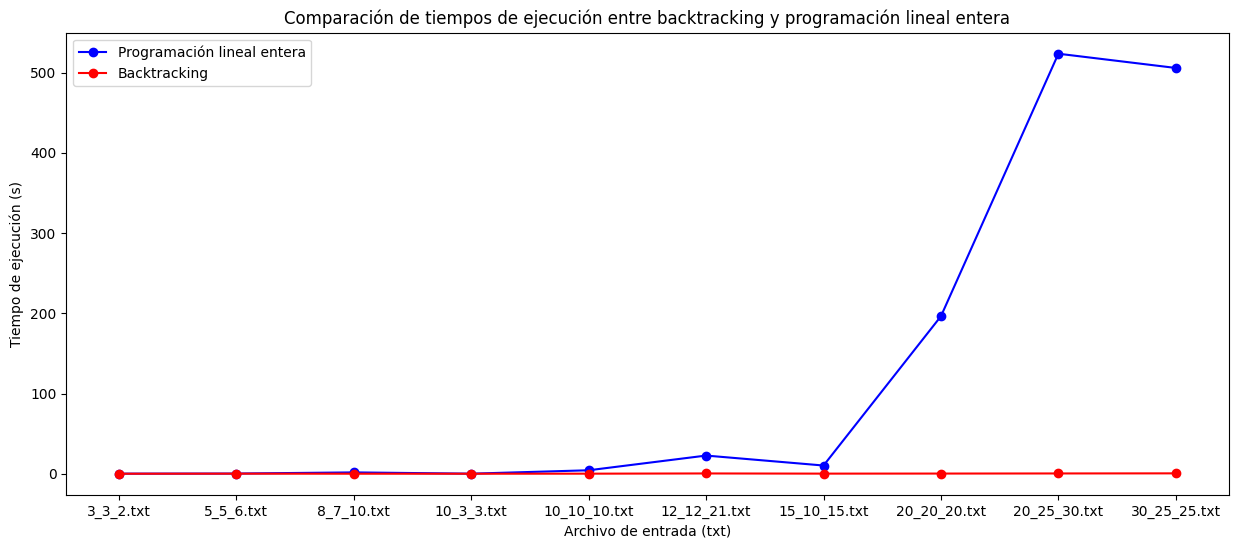

In [23]:
#Gráfico de tiempos de ejecución de prog_lineal vs backtracking
n_tamanios = ['3_3_2.txt', '5_5_6.txt', '8_7_10.txt', '10_3_3.txt', '10_10_10.txt', '12_12_21.txt', '15_10_15.txt','20_20_20.txt','20_25_30.txt', '30_25_25.txt']
tiempos_pl = [tiempo3_3_2, tiempo5_5_6, tiempo8_7_10, tiempo10_3_3, tiempo10_10_10,tiempo12_12_21, tiempo15_10_15,tiempo20_20_20,tiempo20_25_30,tiempo30_25_25]
tiempos_bt = [0.0001459,0.0866703,0.0080757,0.0008003,0.0635857,0.3379466,0.1211435,0.2013275,0.3327887,0.4561674]
plt.figure(figsize=(15, 6))
plt.plot(n_tamanios, tiempos_pl, 'o-', label="Programación lineal entera", color="blue")
plt.plot(n_tamanios, tiempos_bt, 'o-', label="Backtracking", color="red")
plt.xlabel('Archivo de entrada (txt)')
plt.ylabel('Tiempo de ejecución (s)')
plt.legend()
plt.title("Comparación de tiempos de ejecución entre backtracking y programación lineal entera")
plt.show()